In [1]:
import numpy as np
from matplotlib import pyplot as plt
import time
import importlib
from matplotlib import animation as am
from scipy.optimize import root_scalar, minimize
from lin_stability import * 
from sto_density import *
from tqdm import tqdm

In [4]:
kappa = 1
n = 6 
mu = 1.2
nu = 1.2
tau = 5
epsilon = 1

m = model(mu, nu, kappa, n, tau, epsilon)

# First, try to see if there is a uniform solution

If there are three crossings with the x-axis, there are two stable uniform solutions; if there is only one crossing, there is one stable uniform solution 

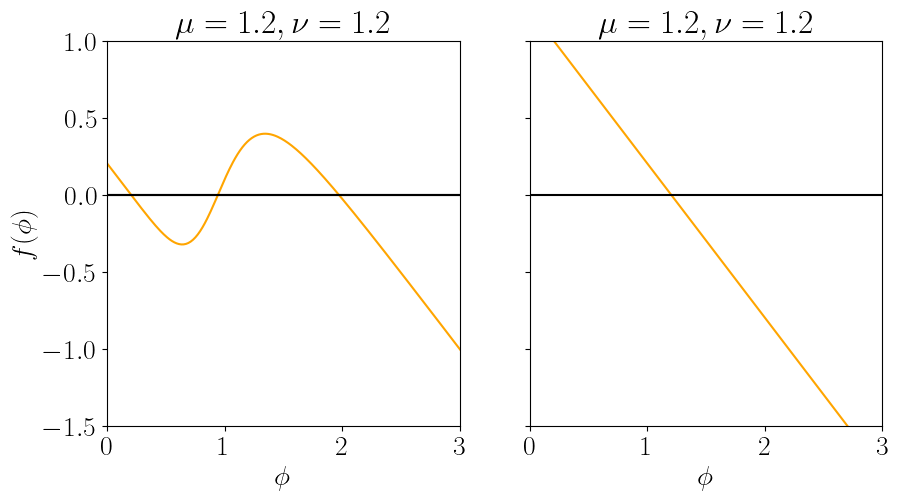

In [7]:
psis = np.arange(0, 5, 0.01)
plt.rc('font', size=20)
plt.rc('text', usetex=True)

fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(10, 5))

m.set_mu_nu(2, 0.2)
axes[0].plot(psis, m.f(psis), color='orange')
axes[0].axhline(y=0, color='k')
axes[0].axhline(y=0, color='k')
axes[0].set_xlim([0, 3])
axes[0].set_ylim([-1.5, 1])
axes[0].set_ylabel(r'$f(\phi)$')
axes[0].set_xlabel(r'$\phi$')
axes[0].set_title(r'$\mu={}, \nu={}$'.format(mu, nu))

m.set_mu_nu(1.2, 1.2)
axes[1].plot(psis, m.f(psis), color='orange')
axes[1].axhline(y=0, color='k')
axes[1].set_xlim([0, 3])
axes[1].set_ylim([-1.5, 1])
axes[1].set_title(r'$\mu={}, \nu={}$'.format(mu, nu))
axes[1].set_xlabel(r'$\phi$')


plt.show() 

# Focus on the case where there is only one stable uniform solution 

In [8]:
m.tau = 0.5 
m.epsilon = 0.1
print('uniform solution:', m.find_phi_bar(8)) # 8: maximum value in the search for phi_bar

uniform solution: 1.2


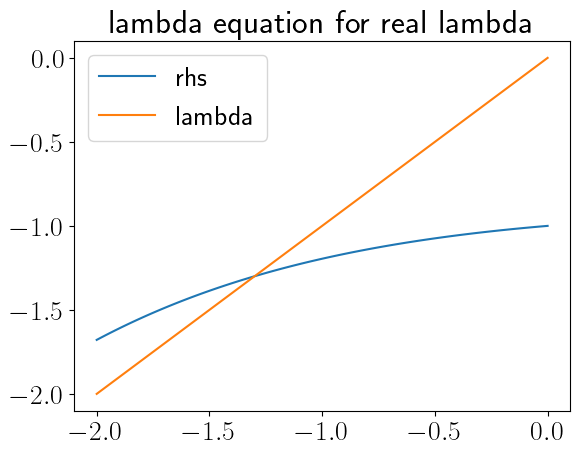

In [9]:
lbdas = np.linspace(-2, 0, 100)
plt.plot(lbdas, m.rhs(lbdas), label='rhs')
plt.plot(lbdas, lbdas, label='lambda')
plt.title('lambda equation for real lambda')
plt.legend() 
plt.show() 

## Look at the behaviour of $\lambda$ when $\sigma = 0$ and when $\omega = 0$ 

In [10]:
try: 
    e_star = m.get_e_star()
    print('e_star = ', e_star)
except Exception:
    print('no threshold value for epsilon')
    
try: 
    tau_star = m.get_tau_star()
    print('tau_star = ', tau_star)
except Exception: 
    print('no threshold value for tau')

e_star =  1.3007719372340625
no threshold value for tau


/Users/yuli/Documents/kuramoto/lin_stability.py:47: RuntimeWarning: invalid value encountered in sqrt
  omega_star = np.sqrt((self.nu_bar-self.mu_bar)**2 - self.kappa**2)


## Look for purely imaginary solutions 

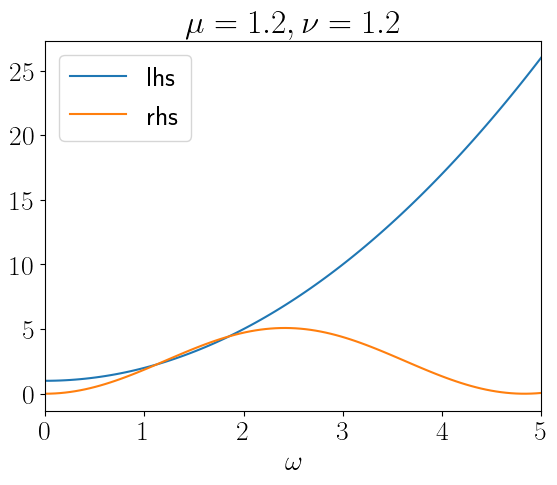

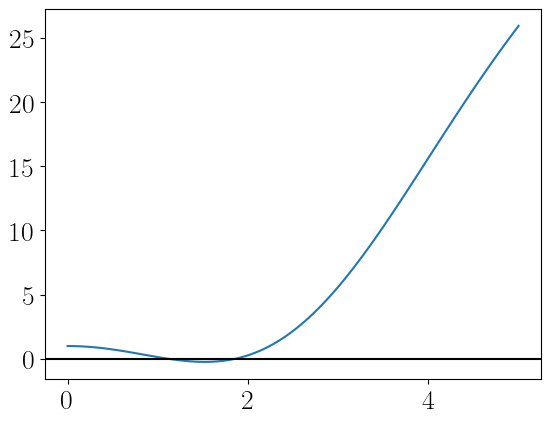

In [11]:
m.epsilon = 1.3
omegas = np.linspace(0, 5, 100)
plt.plot(omegas, m._y1(omegas), label=r'lhs')
plt.plot(omegas, m._y2(omegas), label=r'rhs')
plt.legend() 
plt.xlim([0, 5])
plt.xlabel(r'$\omega$')
plt.title(r'$\mu={}, \nu={}$'.format(mu, nu))
plt.show() 

plt.plot(omegas, m._y1(omegas)-m._y2(omegas))
plt.axhline(y=0, color='k')
plt.show()

In [12]:
roots = m.solve_for_omega(1.3)
print(roots)

[1.1224830904037406, 1.852992699679852]


In [13]:
omega = roots[0]
taus = m.solve_for_tau(omega)
print(taus)
print([m.obtain_grads(omega, tau) for tau in taus])

(5.595920325472981, 11.193497127204235, 16.791073928935493)
[(-0.00576952273911216, 0.09084282559646768), (-0.001711303275384785, 0.050211525363630945), (-0.0008078287612675951, 0.03468567301089473)]


## Numerically compute threshold values for each $\epsilon$

In [25]:
N = 100
epsilons = np.linspace(0.1, 10, N)
taus = np.linspace(1, 20, N)
m.find_phi_bar(8)
res = [] 
for epsilon in epsilons:
    roots = m.solve_for_omega(epsilon)
    if roots is not None: 
        for omega in roots: 
            taus = m.solve_for_tau(omega)
            grads = [m.obtain_grads(omega, t) for t in taus]
            res.append([[epsilon]*3, taus, grads])

In [30]:
T = 5e2
dt = 5e-2
sigma = 1e-3
n_batches = int(T)

N = 100
epsilons = np.linspace(0.1, 10, N)
taus = np.linspace(1, 20, N)
amps = np.empty((N, N))



for (i, epsilon) in tqdm(enumerate(epsilons)): 
    for (j, tau) in enumerate(taus):
        sim = density_field_model(mu, nu, kappa, n, tau, epsilon)
        sim.initialise(T, dt, n_batches, 1.2, sigma)
        sim.evolve() 
        
        y = np.copy(sim.psi[-200:]).flatten() 
        y_k = np.abs(np.fft.rfft(y)[1:])

        amps[i, j] = y_k.max() 

100it [07:32,  4.52s/it]


In [31]:
np.save('Sims/amps2.npy', amps)

In [28]:
amps = np.load('Sims/amps2.npy')
epsilons = np.linspace(0.1, 10, N)
taus = np.linspace(1, 20, N)

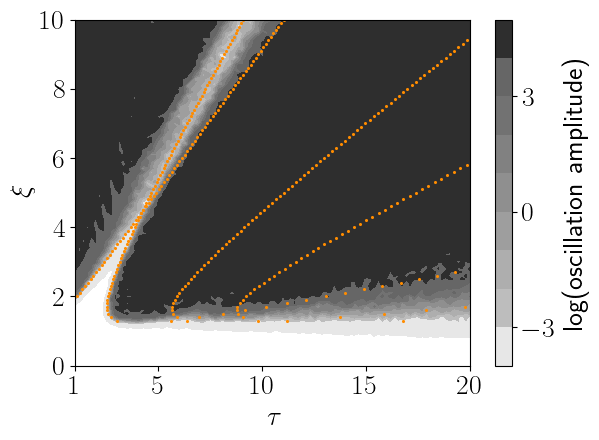

In [31]:
plt.rcParams['text.usetex'] = True
plt.rc('font', size=20)

image = amps
plt.contourf(taus, epsilons, np.log(image), levels=[-10, -3, -2, -1, 0, 1, 2, 3, 4, 10], cmap='Greys') 
cbar = plt.colorbar() 
cbar.set_label(r'log(oscillation amplitude)')
cbar.set_ticks([-3, 0, 3])
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\xi$')

for (es, ts, grads) in res:
    plt.scatter(ts, es, color='darkorange', s=1.5, marker='o')  
        
plt.xlim([1, 20])
plt.ylim([0, 10])
plt.xticks([1, 5, 10, 15, 20])
plt.tight_layout()
plt.savefig('Figures/2d_map.pdf')
plt.show() 